# Review
Hi, my name is Dmitry and I will be reviewing your project.

You can find my comments in colored markdown cells:

<div class="alert alert-success">
    If everything is done successfully.
</div>

<div class="alert alert-warning">
    If I have some (optional) suggestions, or questions to think about, or general comments.
</div>

<div class="alert alert-danger">
    If a section requires some corrections. Work can't be accepted with red comments.
</div>

Please don't remove my comments, as it will make further review iterations much harder for me.

Feel free to reply to my comments or ask questions using the following template:

<div class="alert alert-info">
    For your comments and questions.
</div>

First of all, thank you for turning in the project! You did a great job! The project is accepted. Good luck on the next sprint!

# Project description

You work for the OilyGiant mining company. Your task is to find the best place for a new well.

Steps to choose the location:

- Collect the oil well parameters in the selected region: oil quality and volume of reserves;
- Build a model for predicting the volume of reserves in the new wells;
- Pick the oil wells with the highest estimated values;
- Pick the region with the highest total profit for the selected oil wells.

You have data on oil samples from three regions. Parameters of each oil well
in the region are already known. Build a model that will help to pick the region
with the highest profit margin. Analyze potential profit and risks using the
Bootstrap technique.

# Data Description

Geological exploration data for the three regions are stored in files:

`geo_data_0.csv`, `geo_data_1.csv`, `geo_data_2.csv` 

`id` — unique oil well identifier

`f0`, `f1`, `f2` — three features of points (their specific meaning is unimportant, but the features themselves are significant)

`product` — volume of reserves in the oil well (thousand barrels).

# Table of Content

<div> 
    <ol>
      <li><a href="#1"> Download and prepare the data</a></li>
      <li><a href="#2">Train and test the model for each region</a></li>
      <li><a href="#3">Prepare for profit calculation</a></li>
      <li><a href="#4">Calculate profit from a set of selected oil wells and model predictions</a></li>
      <li><a href="#5"> Calculate risks and profit for each region</a></li>
      <li><a href="#6">Overall conclusion</a></li>
    </ol> 
</div>

# <a id="1">Download and prepare the data

In [1]:
# import pandas and numpy for data preprocessing and manipulation
import numpy as np
import pandas as pd
from scipy import stats as st

# seaborn and matplotlib for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import train_test_split to split data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None # to avoid SettingWithCopyWarning after scaling

# import machine learning module from the sklearn library
from sklearn.linear_model import LinearRegression # import linear regression 

# import regression metrics
from sklearn.metrics import explained_variance_score 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# import warnings
import warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [3]:
# function to check na percent within the data
def get_percent_of_na(df, num):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index, s.values):
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('Column {} has {:.{}%} percent of Nulls, and {} of nulls'.format(column, percent, num, num_of_nulls))
    if count != 0:
        print("\033[1m" + 'There are {} columns with NA.'.format(count) + "\033[0m")
    else:
        print()
        print("\033[1m" + 'There are no columns with NA.' + "\033[0m")
        
# function to display general information about the dataset
def get_info(df):
    """
    This function uses the head(), info(), describe(), shape() and duplicated() 
    methods to display the general information about the dataset.
    """
    print("\033[1m" + '-'*100 + "\033[0m")
    print('Head:')
    print()
    display(df.head())
    print('-'*100)
    print('Info:')
    print()
    display(df.info())
    print('-'*100)
    print('Describe:')
    print()
    display(df.describe())
    print('-'*100)
    display(df.describe(include='object'))
    print()
    print('Columns with nulls:')
    display(get_percent_of_na(df, 4))  # check this out
    print('-'*100)
    print('Shape:')
    print(df.shape)
    print('-'*100)
    print('Duplicated:')
    print("\033[1m" + 'We have {} duplicated rows.\n'.format(df.duplicated().sum()) + "\033[0m")
    print()

In [4]:
def display_group_density_plot(df, groupby, on, palette, figsize):
    """
    Displays a density plot by group, given a continuous variable, and a group to split the data by
    :param df: DataFrame to display data from
    :param groupby: Column name by which plots would be grouped (Categorical, maximum 10 categories)
    :param on: Column name of the different density plots
    :param palette: Color palette to use for drawing
    :param figsize: Figure size
    :return: matplotlib.axes._subplots.AxesSubplot object
    """

    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError('df must be a pandas DataFrame')

    if not groupby:
        raise ValueError('groupby parameter must be provided')

    elif not groupby in df.keys():
        raise ValueError(groupby + ' column does not exist in the given DataFrame')

    if not on:
        raise ValueError('on parameter must be provided')

    elif not on in df.keys():
        raise ValueError(on + ' column does not exist in the given DataFrame')

    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10]

    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    # Plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on], \
                    shade=True, color=color, label=value)

    ax.set_title(str("Distribution of " + on + " per " + groupby + " group"),\
                 fontsize=30)
    
    ax.set_xlabel(on, fontsize=20)
    ax.legend()
    return ax

Get the general infos about the dataframe

In [5]:
get_info(geo_data_0)

----------------------------------------------------------------------------------------------------
Head:



,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

----------------------------------------------------------------------------------------------------
Describe:



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


----------------------------------------------------------------------------------------------------


,id
count,100000
unique,99990
top,AGS9W
freq,2



Columns with nulls:

There are no columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(100000, 5)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.




In [6]:
get_info(geo_data_1)

----------------------------------------------------------------------------------------------------
Head:



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

----------------------------------------------------------------------------------------------------
Describe:



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


----------------------------------------------------------------------------------------------------


,id
count,100000
unique,99996
top,wt4Uk
freq,2



Columns with nulls:

There are no columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(100000, 5)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.




In [7]:
get_info(geo_data_2)

----------------------------------------------------------------------------------------------------
Head:



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

----------------------------------------------------------------------------------------------------
Describe:



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


----------------------------------------------------------------------------------------------------


,id
count,100000
unique,99996
top,Vcm5J
freq,2



Columns with nulls:

There are no columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(100000, 5)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.




- Check correlation for each region variables 

In [8]:
def pairplot(df):
    cols = ['f0', 'f1', 'f2', 'product']
    ax = sns.pairplot(df, vars=cols)
    ax.fig.suptitle('Relationship between parameters for geological data', y=1.02)

- Function to plot correlation matrix for each geological data

In [9]:
def corr_matrix(df, label):
    plt.figure(figsize=(8,6))
    corrMatrix = df.corr()
    sns.heatmap(corrMatrix, annot=True)
    plt.title('Correlation matrix for ' + label)
    plt.show()

**1. geo_data_0**

- Pairplot

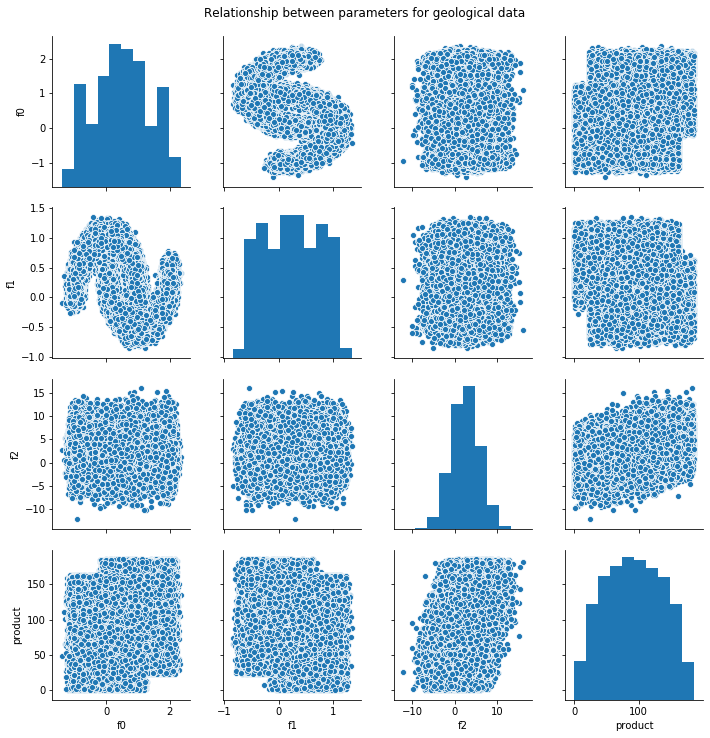

In [10]:
pairplot(geo_data_0)

- Correlation Matrix

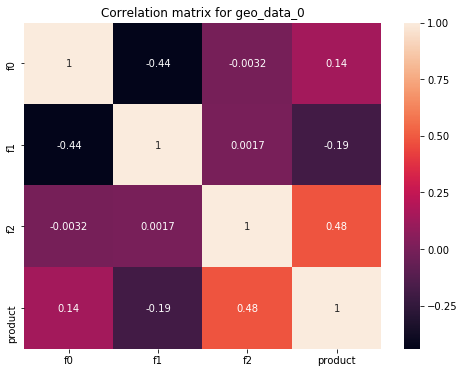

In [11]:
corr_matrix(geo_data_0, 'geo_data_0')

**2. geo_data_1**

- Pairplot

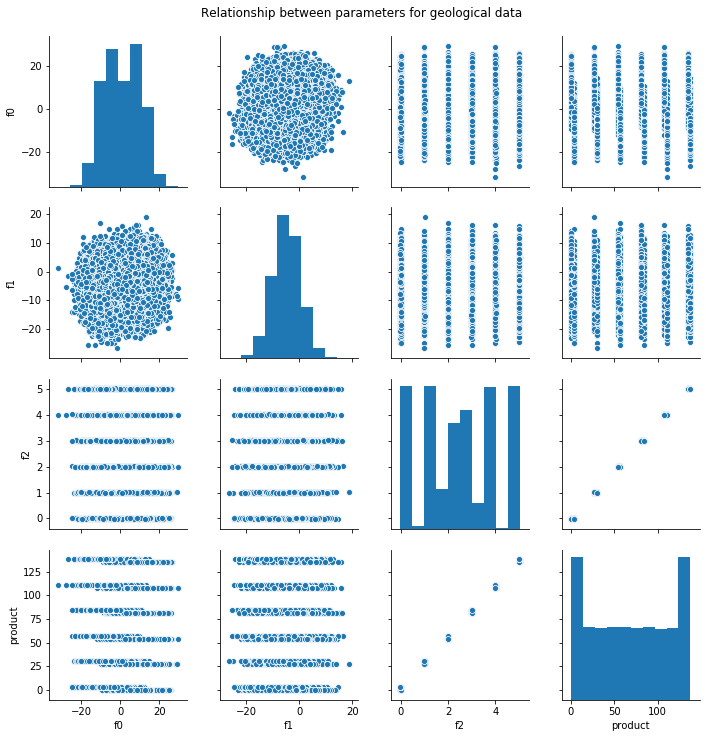

In [12]:
pairplot(geo_data_1)

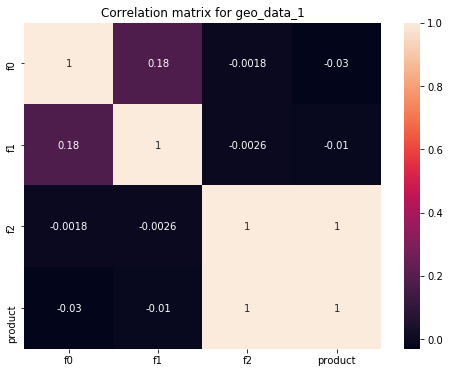

In [13]:
corr_matrix(geo_data_1, 'geo_data_1')

**3. geo_data_2**

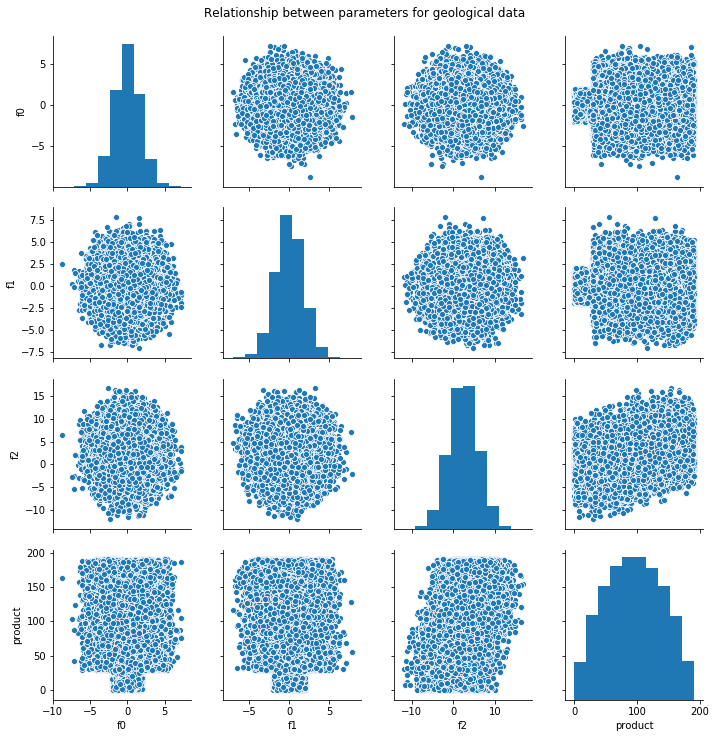

In [14]:
pairplot(geo_data_2)

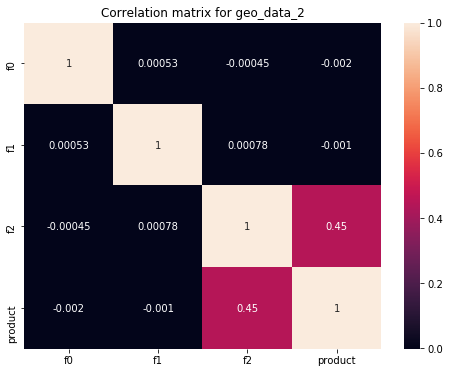

In [15]:
corr_matrix(geo_data_2, 'geo_data_2')

**Conclusion**

We can see that:
- Our datasets don't contain any missing values and have the same counts.
- In `geo_data_0`, f2 is normally distributed and has a high correlation of 0.48 to the `product`
- In `geo_data_1`, f2 is linearly correlated with `product`
- In `geo_data_2`, f1, f2, and f3 are all normally distributed. Also f2 has a high correlation of 0.45 to the `product`

<div class="alert alert-success">
    <b>Reviewer's comment</b><br>
    Great, the data was loaded and inspected!
</div>

# <a id="2">Train and test the model for each region

In this part we will We split the data into:
- 75% training set
- 25% testing set

We will train our model on the training set, to be able to predict after that the volume of reserves in the oil well.

In [22]:
# function to train a model and make predictions
def train_test_predict(df):
    """ 
    This function declares variables for features and target,
    splits the data into train and test sets, trains the model
    and make predictions using linear regression algorithm
    """
    # drop unimportant features
    df = df.drop(['id'], axis=1)

    # declare variables for features and target
    target = df['product']
    features = df.drop(['product'], axis=1)

    # split data into 75% training and 25% testing sets
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.25, random_state=12345
    )
    
    # features scaling
    scaler = StandardScaler()
    scaler.fit(features_train)
    # transform the training set and the test set using transform()
    features_train = scaler.transform(features_train)
    features_test  = scaler.transform(features_test)

    # linear regression model
    model = LinearRegression()
    model.fit(features_train, target_train) # train model
    test_predictions = pd.Series(model.predict(features_test), index=target_test.index) # make prediction using test set
    return test_predictions, target_test

# function to calculate regression metrics
def reg_metrics(y_test, y_pred):
    print('Mean absolute error: %.2f' % mean_absolute_error(y_test, y_pred))
    print('Explained variance score: %.4f' % explained_variance_score(y_test, y_pred))
    print('Mean squared error: %.3f' % mean_squared_error(y_test, y_pred))
    print("RMSE: %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
    print('Variance score: %.4f' % r2_score(y_test, y_pred)) # coeff. of determination
    forecast_err = np.array(y_test) - np.array(y_pred)
    print('Forecast bias: %.4f' % (np.sum(forecast_err) * 1.0/len(y_pred)))

**geo_data_0**

In [23]:
# store predictions and test data sets
test_predictions_0, target_test_0 = train_test_predict(geo_data_0)

# regression metric for geo_data_0
reg_metrics(test_predictions_0, target_test_0)

Mean absolute error: 30.92
Explained variance score: -1.6286
Mean squared error: 1412.213
RMSE: 37.5794
Variance score: -1.6291
Forecast bias: 0.5140


- Volume of predicted reserves and actual reserves

In [24]:
print('Average volume of reserves: %.2f' % target_test_0.mean())
print('The average volume of predicted reserves is: %.2f' % test_predictions_0.mean())
print("The model's RMSE is : %.4f" % np.sqrt(mean_squared_error(test_predictions_0, target_test_0)))

Average volume of reserves: 92.08
The average volume of predicted reserves is: 92.59
The model's RMSE is : 37.5794


**geo_data_1**

In [25]:
# store predictions and test data sets
test_predictions_1, target_test_1 = train_test_predict(geo_data_1)

# regression metric for region 2
reg_metrics(test_predictions_1, target_test_1)

Mean absolute error: 0.72
Explained variance score: 0.9996
Mean squared error: 0.798
RMSE: 0.8931
Variance score: 0.9996
Forecast bias: 0.0054


In [26]:
# volume of predicted reserves and actual reserves
print('Average volume of reserves: %.2f' % target_test_1.mean())
print('The average volume of predicted reserves is: %.2f' % test_predictions_1.mean())
print("The model's RMSE is : %.4f" % np.sqrt(mean_squared_error(test_predictions_1, target_test_1)))

Average volume of reserves: 68.72
The average volume of predicted reserves is: 68.73
The model's RMSE is : 0.8931


**geo_data_2**

In [27]:
# store predictions and test data sets
test_predictions_2, target_test_2 = train_test_predict(geo_data_2)

# regression metric for region 2
reg_metrics(test_predictions_2, target_test_2)

Mean absolute error: 32.79
Explained variance score: -3.0653
Mean squared error: 1602.378
RMSE: 40.0297
Variance score: -3.0653
Forecast bias: 0.0808


In [28]:
# volume of predicted reserves and actual reserves
print('Average volume of reserves: %.2f' % target_test_2.mean())
print('The average volume of predicted reserves is: %.2f' % test_predictions_2.mean())
print("The model's RMSE is : %.4f" % np.sqrt(mean_squared_error(test_predictions_2, target_test_2)))

Average volume of reserves: 94.88
The average volume of predicted reserves is: 94.97
The model's RMSE is : 40.0297


**Conclusion**

In this part we:
- predicted the volume of reserves in the oil well (in thousand bbls)
- calculated different regression metrics
We can observe that:
- in `geo_data_0`:
    - the R2 metric is -1.62 which means the model quality is low
    - the mean error for each well is 30.92 thousand barrels
    - the high RMSE value of 37.58 thousand barrels indicates that maybe there are outliers in the data.
    - the model is overpredicting average reserves
- in `geo_data_1`:
    - the R2 metric is 0.9996 which indicates that the model quality is good
    - low MAE value of 0.72 thousand barrels means that the model is a perfect predictor of the reserve in this region
    - low RMSE value of 0.89 thousand barrels indicates that the model is giving a prediction close to the actual reserve
- in `geo_data_2`:
    - R2 metric is very low at -3.06 indicating poor model quality
    - high MAE value of 32.79 thousand barrels, and high RMSE value of 40.03 thousand barrels, both indicate an overprediction of average value of reserves by the model

And this is a summary of our results

|**Regions**| **Average Actual Reserve (in thousands STB)**  | **Average Predicted Reserve (in thousands STB)**  | **RMSE**  | **MAE**  |
|---|---|---|---|---|
| geo_data_0|92.08  | 92.59	| 37.58	| 30.92  |
| geo_data_1| 68.72 | 68.73 | 0.89  | 0.72   |
| geo_data_2| 94.88 | 94.97 | 40.03 | 32.79  |

<div class="alert alert-success">
    <b>Reviewer's comment</b><br>
    The data was split into train and test, the models were trained and evaluated correctly, predictions and true values for the test set were saved for use in bootstrapping
</div>

# <a id="3">Prepare for profit calculation

In [29]:
#Store key values in separate variables
# profit determination conditions
region_points = 500 # 500 oil wells required
best_region_for_profit = 200 # 200 oil wells 
capital_cost = 100 * 10**6 # development budget for 200 wells (100 USD million)
cost_per_bbl = 4.5 # revenue from 1 unit of product (in thousand barrels) = $4,500 
risk_of_losses = 0.025

In [30]:
# calculate the volume of reserves for developing new well without losses
# volume of reserves calculation
revenue = cost_per_bbl * best_region_for_profit
volume_of_reserves = capital_cost / revenue
print('The volume of reserves required to develop a new well without loss: %.2f' % volume_of_reserves, 'Stock Tank Barrels (STB).')

The volume of reserves required to develop a new well without loss: 111111.11 Stock Tank Barrels (STB).


- By calculating the volume of reserves sufficient to develop a new well without loss as 111.11 thousand barrels. This volume will be our baseline value. 
- when comparing this value to the average volume of reserves in each region, we can see that average volume of reserves in each region is lower than 111.11 thousand barrels.

<div class="alert alert-success">
    <b>Reviewer's comment</b><br>
    Calculations are correct!
</div>

# <a id="4">Calculate profit from a set of selected oil wells and model predictions

In [31]:
# function to calculate the highest prediction in each region
def highest_prediction(y_test, y_pred, count):
    highest_reserves_volume_predicted = y_pred.sort_values(ascending=False)
    selected_reserves_volume_target = y_test[highest_reserves_volume_predicted.index][:count]
    total_selected_reserves_volume_target = selected_reserves_volume_target.sum() * 1000
    print('The highest prediction value in this region is: %.2f' % total_selected_reserves_volume_target,
          'STB or %.2f' % (total_selected_reserves_volume_target / 10**6), 'MMSTB')

# function to calculate profit from a set of selected oil wells and model predictions
def reserves_profit(y_test, y_pred, count):
    highest_reserves_volume_predicted = y_pred.sort_values(ascending=False)
    selected_reserves_volume_target = y_test[highest_reserves_volume_predicted.index][:count]
    total_selected_reserves_volume_target = selected_reserves_volume_target.sum() * 1000
    selected_reserves_profit = total_selected_reserves_volume_target * cost_per_bbl - capital_cost
    print('The selected reserves profit is: $%.2f' % selected_reserves_profit)

**In this part we will check regions with the highest values of predictions**

**geo_data_0**

In [32]:
# highest value prediction in region 1
highest_prediction(target_test_0, test_predictions_0, 200)

The highest prediction value in this region is: 29601835.65 STB or 29.60 MMSTB


**geo_data_1**

In [33]:
# highest value prediction in region 2
highest_prediction(target_test_1, test_predictions_1, 200)

The highest prediction value in this region is: 27589081.55 STB or 27.59 MMSTB


**geo_data_2**

In [34]:
# highest value prediction in region 3
highest_prediction(target_test_2, test_predictions_2, 200)

The highest prediction value in this region is: 28245222.14 STB or 28.25 MMSTB


- We can observe that `geo_data_0` has the highest prediction of the three regions. `geo_data_0` has the highest estimated reserve among the three regions.

**Profit for obtained volume of reserves in each region**

**geo_data_0**

In [35]:
# profit from a set of selected oil wells and model predictions in region 1
reserves_profit(target_test_0, test_predictions_0, 200)

The selected reserves profit is: $33208260.43


**geo_data_1**

In [36]:
# profit from a set of selected oil wells and model predictions in region 2
reserves_profit(target_test_1, test_predictions_1, 200)

The selected reserves profit is: $24150866.97


**geo_data_2**

In [37]:
# profit from a set of selected oil wells and model predictions in region 3
reserves_profit(target_test_2, test_predictions_2, 200)

The selected reserves profit is: $27103499.64


- We can see that the highest profit is in `geo_data_0` with 33 million USD. 
- it's better for OilyGiant mining company to channel more drilling activities in this region.

<div class="alert alert-warning">
    <b>Reviewer's comment</b><br>
    Sure, but that's only if we can test all possible well locations and select the top 200, but that's not possible
</div>

# <a id="5">Calculate risks and profit for each region

-  bootstrapping technique for profit distribution

In [38]:
# compute distribution of profits
def revenue(y_test, y_pred, count):
    highest_reserves_volume_predicted = y_pred.sort_values(ascending=False)
    selected_reserves_volume_target = y_test[highest_reserves_volume_predicted.index][:count]
    total_selected_reserves_volume_target = selected_reserves_volume_target.sum() * 1000
    selected_reserves_profit = total_selected_reserves_volume_target * cost_per_bbl - capital_cost
    return selected_reserves_profit

# compute profit from 1000 samples of revenue using bootstrapping technique
def bootstrapping_revenue(y_test, y_pred):
    state = np.random.RandomState(12345) 
    
    # store the 99% quantile values to the profit variable
    profit = []
    for i in range(1000):
        target_subsample = y_test.sample(n=region_points, replace=True, random_state=state)
        predicted_subsample = y_pred[target_subsample.index]
        profit.append(revenue(target_subsample, predicted_subsample, best_region_for_profit))
    return pd.Series(profit)

# compute bootstrap profit, confidence interval and risk of losses
def bootstrap_profit_ci_risk(y_test, y_pred):
    profit = bootstrapping_revenue(y_test, y_pred) # change type for convenience
    mean_profit = profit.mean() # average profit
    confidence_interval = st.t.interval(
        0.95, len(profit)-1, mean_profit, profit.sem()
    ) # 95% C.I.
    losses = profit[profit < 0]
    risk_of_losses = len(losses) / len(profit)
    print('The average profit is: %.2f' % mean_profit)
    print('The 95% confidence interval: ', confidence_interval)
    print('The risk of losses is: {:.2%}'.format(risk_of_losses))

- We look at the average profit, 95% confidence intervals, and risk of losses in each region: 

**geo_data_0**

In [39]:
# average profit, 95% C.I., and risk in geo_data_0
bootstrap_profit_ci_risk(target_test_0, test_predictions_0)

The average profit is: 4259385.27
The 95% confidence interval:  (4087322.0706869857, 4431448.467524861)
The risk of losses is: 6.00%


**geo_data_1**

In [40]:
# average profit, 95% C.I., and risk in geo_data_1
bootstrap_profit_ci_risk(target_test_1, test_predictions_1)

The average profit is: 5152227.73
The 95% confidence interval:  (5016214.761763218, 5288240.707102581)
The risk of losses is: 1.00%


**geo_data_2**

In [41]:
# average profit, 95% C.I., and risk in geo_data_2
bootstrap_profit_ci_risk(target_test_2, test_predictions_2)

The average profit is: 4350083.63
The 95% confidence interval:  (4174535.520413578, 4525631.735241534)
The risk of losses is: 6.40%


**Profit Distribution**

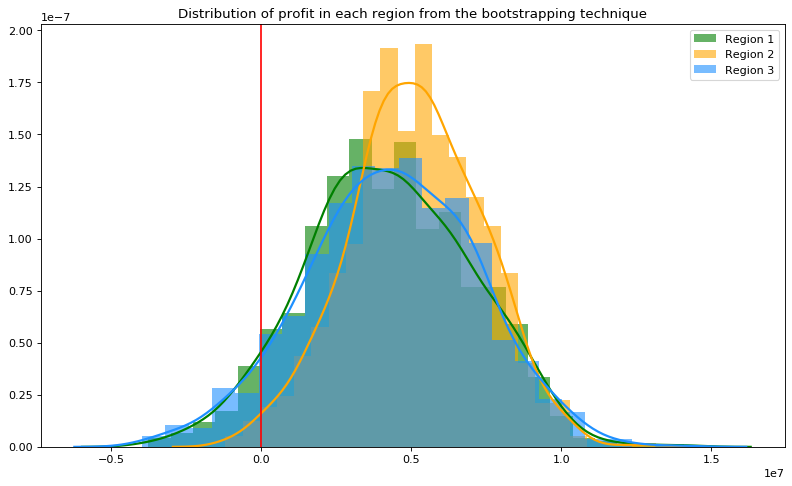

In [42]:
# profit from each region
region_1_profit = bootstrapping_revenue(target_test_0, test_predictions_0)
region_2_profit = bootstrapping_revenue(target_test_1, test_predictions_1)
region_3_profit = bootstrapping_revenue(target_test_2, test_predictions_2)

# distribution plot
kwargs = dict(hist_kws={'alpha': 0.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(12,7), dpi= 80)
sns.distplot(region_1_profit, color='green', label='Region 1', **kwargs)
sns.distplot(region_2_profit, color='orange', label='Region 2', **kwargs)
sns.distplot(region_3_profit, color='dodgerblue', label='Region 3', **kwargs)
plt.axvline(0, c="r")
plt.title('Distribution of profit in each region from the bootstrapping technique')
plt.legend();

- We summarize the results in this table:

|**Regions**| **Average Profit (USD)**  | **95% C.I.**  | **Risk of losses**  |
|---|---|---|---|
| geo_data_0|	4259385.27 | (4087322.07, 4431448.47)		| 6.00%	| 
| geo_data_1| 5152227.73 | (5016214.76, 5288240.71) | 1.00%  | 
| geo_data_2| 	4350083.63 | (4174535.52, 4525631.74) | 	6.40% | 

From the use of bootstrapping technique we can see that `geo_data_1` has:
- the highest distribution of profit. 
- the highest average profit and the lowest risk of losses. 

<div class="alert alert-success">
    <b>Reviewer's comment</b><br>
    Bootstrapping is done correctly, average profit, 95% confidence interval and risk of losses were calculated successfully
</div>

# <a id="6">Overall conclusion

The business task of this project is is to find the best place for a new well for the  OilyGiant mining company.

- In the first part, we downloaded the 3 region datasets and investigated the general information. 
    - We’ve seen that there is no missing values. 
    - Each region dataset contains 100000 rows and 3 features. 
    - We plotted the pairplot and correlation matrix for each region in order to observe correlations between features in each region. We conclude that:
        - In `geo_data_0`, f2 is normally distributed and has a high correlation of 0.48 to the product
        - In `geo_data_1`, f2 is linearly correlated with product
        - In `geo_data_2`, f1, f2, and f3 are all normally distributed. Also f2 has a high correlation of 0.45 to the product
- Then, we splitted the data into:
    - 75% training set, 25% testing set
    - We standardized the numerical features of the data. 
    - The resulting table has 75000 rows and 3 features for the train features set, and 25000 rows and 3 features for the test features set. 
    - We trained the model and made predictions using a Linear Regression Algorithm.
    - We predicted the volume of reserves in the oil well (in thousand bbls). 
    - We also calculated different regression metrics. 
    - we’ve seen that in: 
        - `geo_data_0`, the R2 metric is -1.62 which means the model quality is low, the mean error for each well is 30.92 thousand barrels, and the high RMSE value of 37.58 thousand barrels indicates that there may be outliers in the data.
        - `geo_data_1`, the R2 metric is 0.9996 which indicates that the model quality is good. The low MAE value of 0.72 thousand barrels means that the model is a perfect predictor of the reserve in this region, and the low RMSE value of 0.89 thousand barrels indicates that the model is giving a prediction close to the actual reserve. 
        - `geo_data_2`, the R2 metric is very low at -3.06 indicating poor model quality in this region. The high MAE value of 32.79 thousand barrels, and high RMSE value of 40.03 thousand barrels indicate an overprediction of average value of reserves by the model in `geo_data_2`.
- We calculated the volume of reserves sufficient to develop a new well without loss, as 111.11 thousand barrels.
    - comparing this value to the average volume of reserves in each region, we see that average volume of reserves in each region is lower than 111.11 thousand barrels. 
- We developed a function to calculate profit from a set of selected oil wells and model predictions. From the calculation on highest values of prediction, we can see that `geo_data_0` has the highest prediction of the three regions. `geo_data_0` can be a promising region to continue more drilling activities.
- We applied the bootstrapping technique to find the distribution of profit. We computed the average profit, 95% confidence interval, and risk of losses. From the calculations done, we observed that 
    - `geo_data_1` has the highest distribution of profit, highest average profit and the lowest risk of losses than any other region. Since `geo_data_1` generated the highest average profit than other regions with a risk of losses lower than 2.5%, we can recommend that OilyGiant mining company should focus more on `geo_data_1` for the oil wells' development.
    
So we’ve developed a machine learning model that optimizes well placement, predicts the volume of reserves in new wells, picks the oil wells with the highest estimated reserve, and the region with the highest total profit. Which will help OilyGiant during the decision-making process to determine whether a production project will be profitable or not. 

<div class="alert alert-success">
    <b>Reviewer's comment</b><br>
    Nice summary! Conclusions are consistent with the data and make sense!
</div>